# Data Processing

Starting with the BeautifulSoup objects for each page we are going to extract the following features: 

1) The date published 
2) The headline of the article
3) The description
4) The main body of the review
5) User comments

Each feature will have it's own section in the notebook including a function to extract it and steps taken for quality control. 

In [1]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup 
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
review_data=pd.read_csv('Running_dataset')
review_data['page']=review_data['page'].apply(lambda x: BeautifulSoup(x, 'html.parser'))

In [3]:
review_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1163 entries, 0 to 1162
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   link    1163 non-null   object
 1   page    1163 non-null   object
dtypes: object(2)
memory usage: 18.3+ KB


## Section 1: Date

In [4]:
def get_date(page):
    try: 
        date=page.find(itemprop="datePublished")['content']
    except:
        date='No tag found'
    return date

Now we need to search for missing date values using the 'no tag found' string included in the above function 

## Test 1

In [5]:
#check for null values
review_data['page'].apply(lambda page:get_date(page)).info()

<class 'pandas.core.series.Series'>
RangeIndex: 1163 entries, 0 to 1162
Series name: page
Non-Null Count  Dtype 
--------------  ----- 
1163 non-null   object
dtypes: object(1)
memory usage: 9.2+ KB


In [6]:
#check for no date found
No_date=review_data[review_data['page'].apply(lambda page:get_date(page))=='No tag found']
print(No_date.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1 entries, 760 to 760
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   link    1 non-null      object
 1   page    1 non-null      object
dtypes: object(2)
memory usage: 24.0+ bytes
None


In [7]:
#as there is only one item let's check it's link 
No_date['link'].iloc[0]

'https://www.runningshoesguru.com/2016/09/pearl-izumi-trail-n2v3-review/'

Inspecting the only page that is missing a date we see that it's just blank apart from a title. On the basis this is not valuable for our dataset, let's exclude it

In [8]:
#remove this link
review_data=review_data[review_data['link']!=No_date['link'].iloc[0]]

## Add date column

In [9]:
#add date column
review_data['date']=review_data['page'].apply(lambda page:get_date(page))

After adding this column, we want to check all have valid dates a plausible range, to do this let's try to convert the column to date time and plot the results by year. 

<BarContainer object of 13 artists>

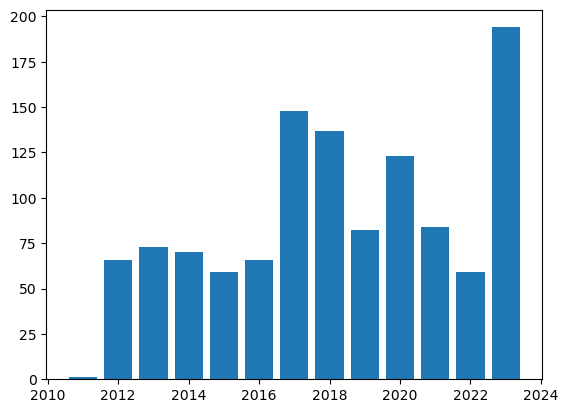

In [10]:
year_counts=pd.to_datetime(review_data['date']).apply(lambda x : x.year)
years=year_counts.value_counts().sort_index().index
counts=year_counts.value_counts().sort_index().values

plt.figure()
plt.bar(years,counts)



This looks fine. As this is a personal project, I'm looking to show what could be possible with this dataset while not taking traffic from the original site. To ensure the copyright of the website is protected, I decided to exclude all reviews from the last 2 years (from October 2023). As running shoe models change frequently, this will mean that any tools I build with this data will not directly compete with the site on providing up to date information. 

In [11]:
review_data=review_data[pd.to_datetime(review_data['date'])<datetime(2021,10,1).astimezone()]

## Section 2: Headline

In [12]:
def get_headline(page):
    try: 
        date=page.find(itemprop="name")['content']
    except:
        date='No tag found'
    return date

## Test 2

First we should check for pages where get_headline returns no headline 

In [13]:
#check for null values
review_data['page'].apply(lambda x: get_headline(x)).info()

<class 'pandas.core.series.Series'>
Int64Index: 898 entries, 0 to 1162
Series name: page
Non-Null Count  Dtype 
--------------  ----- 
898 non-null    object
dtypes: object(1)
memory usage: 14.0+ KB


In [14]:
#check for no headline found
no_headline=review_data[review_data['page'].apply(lambda x: get_headline(x))=='No tag found']
print('pages without a headline =',np.shape(no_headline)[0])

pages without a headline = 0


Great, now we have seen every page has a headline, let's check for repeats 

In [15]:
review_data['page'].apply(lambda x: get_headline(x)).value_counts()

Adidas Energy Boost           3
Hoka One One Speedgoat 2      2
Hoka One One Stinson ATR 4    1
Puma Faas 800                 1
New Balance 1260              1
                             ..
Nike Epic React Flyknit 2     1
Brooks Transcend 4            1
Asics GlideRide 2             1
Asics Gel Contend 4           1
Nike Air Zoom Pegasus 34      1
Name: page, Length: 895, dtype: int64

We have repeats for 2 headlines, let's check Adidas first 

In [16]:
#find repeated headlines
duplicate_Adidas=review_data[review_data['page'].apply(lambda x: get_headline(x))=='Adidas Energy Boost']
print(duplicate_Adidas['link'].iloc[0])
print(duplicate_Adidas['link'].iloc[1])
print(duplicate_Adidas['link'].iloc[2])

https://www.runningshoesguru.com/2017/07/adidas-energy-boost-2017-review/
https://www.runningshoesguru.com/2013/11/adidas-energy-boost-review-2/
https://www.runningshoesguru.com/2013/02/adidas-energy-boost-review/


Checking these page links we can see that there is one pair of duplicates and one later and distinct review. now check Hoka

In [17]:
duplicate_Hoka=review_data[review_data['page'].apply(lambda x: get_headline(x))=='Hoka One One Speedgoat 2']
print(duplicate_Hoka['link'].iloc[0])
print(duplicate_Hoka['link'].iloc[1])

https://www.runningshoesguru.com/2017/09/hoka-one-one-speedgoat-2-review/
https://www.runningshoesguru.com/review/hoka-one-one-speedgoat-2/


This one is a straightforward duplicate. Let's remove the duplicated pages from the data 

In [18]:
#drop the duplictates
review_data=review_data[review_data['link']!=duplicate_Adidas['link'].iloc[1]]
review_data=review_data[review_data['link']!=duplicate_Hoka['link'].iloc[1]]
review_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 896 entries, 0 to 1162
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   link    896 non-null    object
 1   page    896 non-null    object
 2   date    896 non-null    object
dtypes: object(3)
memory usage: 28.0+ KB


## Add headline column

In [19]:
review_data['headline']=review_data['page'].apply(lambda x: get_headline(x))

## Section 3: Description

In [20]:
def get_description(page):
    try: #check for content attribute 
        description=page.find(itemprop="description")['content']
    except: 
        try: #otherwise look for text
            description=page.find(itemprop="description").text
        except: 
            description='no description found'
    return description
    

## Test 3

In [21]:
#check null values
review_data['page'].apply(lambda x: get_description(x)).info()

<class 'pandas.core.series.Series'>
Int64Index: 896 entries, 0 to 1162
Series name: page
Non-Null Count  Dtype 
--------------  ----- 
896 non-null    object
dtypes: object(1)
memory usage: 14.0+ KB


In [22]:
#check for pages with no description tag
no_description=review_data[review_data['page'].apply(lambda x: get_description(x))=='no description found']
print('Number of pages with no description tag =',np.shape(no_description)[0])

Number of pages with no description tag = 0


In [23]:
#check for pages with zero length description
review_data['page'].apply(lambda x: get_description(x)).apply(lambda x: len(x)).sort_values()

495        0
1095      24
785       30
684       35
443       43
        ... 
391      921
1098     925
432      926
533      964
689     1098
Name: page, Length: 896, dtype: int64

Although all pages have a tagged item called description, we can see that a single page is missing it's description as it has length 0

In [24]:
review_data.loc[966] #actually missing description

link        https://www.runningshoesguru.com/2014/01/newto...
page        [b', html,  \n, [ \n, [\n, <link as="style" hr...
date                                2014-01-18T08:55:15-05:00
headline                                Newton Distance Elite
Name: 966, dtype: object

Reviewing the page itself we see that it is missing description so let's drop it from the dataset 

In [25]:
review_data.drop(index=966, inplace=True)

## Add description column 

In [26]:
review_data['description']=review_data['page'].apply(lambda x: get_description(x))

## Section 4: Review body

In [27]:
def get_review_body(page):
    try: 
        review_body=page.find(id="review-body-content").text
    except: 
        review_body='no review body found'
    return review_body

## Test 4

In [28]:
#check null values
review_data['page'].apply(lambda x: get_review_body(x)).info()

<class 'pandas.core.series.Series'>
Int64Index: 895 entries, 0 to 1162
Series name: page
Non-Null Count  Dtype 
--------------  ----- 
895 non-null    object
dtypes: object(1)
memory usage: 14.0+ KB


In [29]:
# check for pages with no review section
no_review_body=review_data[review_data['page'].apply(lambda x: get_review_body(x))=='no review body found']
print('number of pages with no review =',np.shape(no_review_body)[0])

number of pages with no review = 53


In [30]:
#print the links for these pages
no_review_body['link'].head(5)

23     https://www.runningshoesguru.com/review/new-ba...
78     https://www.runningshoesguru.com/review/salomo...
81     https://www.runningshoesguru.com/review/saucon...
83     https://www.runningshoesguru.com/review/nike-z...
103    https://www.runningshoesguru.com/review/nike-w...
Name: link, dtype: object

When we explore what these reviews look like, we can see they have a different format to the main type we have collected, on this basis I've decided to exclude them 

In [31]:
#remove pages with no review body 
review_data=review_data[review_data['page'].apply(lambda x: get_review_body(x))!='no review body found']

In [32]:
review_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 842 entries, 0 to 1162
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   link         842 non-null    object
 1   page         842 non-null    object
 2   date         842 non-null    object
 3   headline     842 non-null    object
 4   description  842 non-null    object
dtypes: object(5)
memory usage: 39.5+ KB


In [33]:
#check character length 
print('min review length (characters) =',review_data['page'].apply(lambda x: get_review_body(x)).apply(lambda x: len(x)).min())
print('max review length (characters) =',review_data['page'].apply(lambda x: get_review_body(x)).apply(lambda x: len(x)).max())

min review length (characters) = 1486
max review length (characters) = 15008


## Add review body column

In [34]:
review_data['review_body']=review_data['page'].apply(lambda x: get_review_body(x))

## Section 5: Customer reviews

In [35]:
#note we don't need try statments for this function as if no tags are found then the loops will not run over the empty lists 
def get_comments(page):
    
    comment_list=[]
    
    for comment in page.find_all(class_="comment-body"):
        comment_paras=comment.find_all('p')
        comment_text=''
    
        for para in comment_paras:
            comment_text+=para.text
        
        comment_list.append(comment_text)

    return comment_list



## Test 5

In [36]:
#check null values
review_data['page'].apply(lambda x: get_comments(x)).info()

<class 'pandas.core.series.Series'>
Int64Index: 842 entries, 0 to 1162
Series name: page
Non-Null Count  Dtype 
--------------  ----- 
842 non-null    object
dtypes: object(1)
memory usage: 13.2+ KB


In [37]:
#check for values with no comments 
no_comments=review_data[review_data['page'].apply(lambda x: len(get_comments(x)))==0]
print('pages with no reviews =',np.shape(no_comments)[0])

pages with no reviews = 100


In [38]:
no_comments['link'].head(5)

33    https://www.runningshoesguru.com/2019/04/hoka-...
35    https://www.runningshoesguru.com/2013/05/new-b...
46    https://www.runningshoesguru.com/2015/09/icebu...
48    https://www.runningshoesguru.com/2016/10/new-b...
52    https://www.runningshoesguru.com/2016/06/the-n...
Name: link, dtype: object

As some pages do not have any user comments, I decided not to exclude these although this should be noted when using the dataset 

## Add user comments 

In [39]:
review_data['comments']=review_data['page'].apply(lambda x: get_comments(x))

## Reset index and save 

After removing multiple sets of missing or null values, the index in our data needs to be reset before saving 

In [40]:
review_data

,link,page,date,headline,description,review_body,comments
0,https://www.runningshoesguru.com/2017/09/hoka-...,"[b', html, \n, [ \n, [\n, <link as=""style"" hr...",2017-09-28T09:49:35-04:00,Hoka One One Stinson ATR 4,The Stinson ATR 4 is built for long days on th...,The Stinson ATR 4 is the newest version of th...,[The bondi 5’s are like boards now-so stiff an...
1,https://www.runningshoesguru.com/2015/08/nike-...,"[b', html, \n, [ \n, [\n, <link as=""style"" hr...",2017-11-25T13:13:48-05:00,Nike Free Flyknit 4.0,It\xe2\x80\x99s hard to believe that the Nike ...,Nike Free Flyknit 4.0 General Info: The Free ...,[Is this shoe recommended for marathons? Pls s...
4,https://www.runningshoesguru.com/2018/08/new-b...,"[b', html, \n, [ \n, [\n, <link as=""style"" hr...",2018-08-15T08:54:42-04:00,New Balance Fresh Foam Beacon,The New Balance Fresh Foam Beacon is a lightwe...,"Light, Airy, Comfortable, Responsive, Flexibl...",[I have 60 miles on my Beacons and I can’t pra...
5,https://www.runningshoesguru.com/2012/09/scott...,"[b', html, \n, [ \n, [\n, <link as=""style"" hr...",2012-09-28T18:38:48-04:00,Scott T2C,The Scott T2C provides an eminently enjoyable ...,Scott T2C General info The T2C is a lightweig...,[I love mine and wish I could still buy them s...
6,https://www.runningshoesguru.com/2016/06/sauco...,"[b', html, \n, [ \n, [\n, <link as=""style"" hr...",2016-06-20T13:09:00-04:00,Saucony Omni 15,The Saucony Omni 15 is the latest and greatest...,The Omni is definitely a unique shoe. It has ...,[Hey! How would you compare these 15s to the 1...
...,...,...,...,...,...,...,...
1155,https://www.runningshoesguru.com/2017/08/sauco...,"[b', html, \n, [ \n, [\n, <link as=""style"" hr...",2017-08-07T00:40:46-04:00,Saucony Omni 16,The Saucony Omni 16 is the perfect shoe for on...,The Omni is a reliable trainer with unique co...,"[I don’t know much about running shoes, so I’v..."
1158,https://www.runningshoesguru.com/2013/01/mizun...,"[b', html, \n, [ \n, [\n, <link as=""style"" hr...",2013-01-26T21:06:46-05:00,Mizuno Wave Evo Cursoris,An excellent foray into the minimalist market ...,Mizuno Wave Evo Cursoris Initial Impressions ...,[In my opinion this is a fantastic shoe with a...
1160,https://www.runningshoesguru.com/2013/12/new-b...,"[b', html, \n, [ \n, [\n, <link as=""style"" hr...",2013-12-01T18:52:00-05:00,New Balance RC 1400v2,The New Balance 1400v2 is a decent light-weigh...,New Balance RC 1400v2 General Information The...,[If you go half size up (like most runners do ...
1161,https://www.runningshoesguru.com/2020/07/reebo...,"[b', html, \n, [ \n, [\n, <link as=""style"" hr...",2020-07-29T01:55:04-04:00,Reebok Forever Floatride Energy 2,The Reebok Forever Floatride Energy 2 is a lig...,Reebok Forever Floatride Energy 2 Intro Reebo...,[No way should these be a 6/10. For the price ...


In [41]:
review_data.reset_index(inplace=True,drop=True)

In [42]:
review_data

,link,page,date,headline,description,review_body,comments
0,https://www.runningshoesguru.com/2017/09/hoka-...,"[b', html, \n, [ \n, [\n, <link as=""style"" hr...",2017-09-28T09:49:35-04:00,Hoka One One Stinson ATR 4,The Stinson ATR 4 is built for long days on th...,The Stinson ATR 4 is the newest version of th...,[The bondi 5’s are like boards now-so stiff an...
1,https://www.runningshoesguru.com/2015/08/nike-...,"[b', html, \n, [ \n, [\n, <link as=""style"" hr...",2017-11-25T13:13:48-05:00,Nike Free Flyknit 4.0,It\xe2\x80\x99s hard to believe that the Nike ...,Nike Free Flyknit 4.0 General Info: The Free ...,[Is this shoe recommended for marathons? Pls s...
2,https://www.runningshoesguru.com/2018/08/new-b...,"[b', html, \n, [ \n, [\n, <link as=""style"" hr...",2018-08-15T08:54:42-04:00,New Balance Fresh Foam Beacon,The New Balance Fresh Foam Beacon is a lightwe...,"Light, Airy, Comfortable, Responsive, Flexibl...",[I have 60 miles on my Beacons and I can’t pra...
3,https://www.runningshoesguru.com/2012/09/scott...,"[b', html, \n, [ \n, [\n, <link as=""style"" hr...",2012-09-28T18:38:48-04:00,Scott T2C,The Scott T2C provides an eminently enjoyable ...,Scott T2C General info The T2C is a lightweig...,[I love mine and wish I could still buy them s...
4,https://www.runningshoesguru.com/2016/06/sauco...,"[b', html, \n, [ \n, [\n, <link as=""style"" hr...",2016-06-20T13:09:00-04:00,Saucony Omni 15,The Saucony Omni 15 is the latest and greatest...,The Omni is definitely a unique shoe. It has ...,[Hey! How would you compare these 15s to the 1...
...,...,...,...,...,...,...,...
837,https://www.runningshoesguru.com/2017/08/sauco...,"[b', html, \n, [ \n, [\n, <link as=""style"" hr...",2017-08-07T00:40:46-04:00,Saucony Omni 16,The Saucony Omni 16 is the perfect shoe for on...,The Omni is a reliable trainer with unique co...,"[I don’t know much about running shoes, so I’v..."
838,https://www.runningshoesguru.com/2013/01/mizun...,"[b', html, \n, [ \n, [\n, <link as=""style"" hr...",2013-01-26T21:06:46-05:00,Mizuno Wave Evo Cursoris,An excellent foray into the minimalist market ...,Mizuno Wave Evo Cursoris Initial Impressions ...,[In my opinion this is a fantastic shoe with a...
839,https://www.runningshoesguru.com/2013/12/new-b...,"[b', html, \n, [ \n, [\n, <link as=""style"" hr...",2013-12-01T18:52:00-05:00,New Balance RC 1400v2,The New Balance 1400v2 is a decent light-weigh...,New Balance RC 1400v2 General Information The...,[If you go half size up (like most runners do ...
840,https://www.runningshoesguru.com/2020/07/reebo...,"[b', html, \n, [ \n, [\n, <link as=""style"" hr...",2020-07-29T01:55:04-04:00,Reebok Forever Floatride Energy 2,The Reebok Forever Floatride Energy 2 is a lig...,Reebok Forever Floatride Energy 2 Intro Reebo...,[No way should these be a 6/10. For the price ...


In [43]:
review_data.to_pickle('Processed_dataset.pkl')